# ViT Deepfake Detection

This notebook trains a Vision Transformer (ViT) model for deepfake detection using the Dataset folder.


In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt

from transformers import (
    ViTForImageClassification,
    get_cosine_schedule_with_warmup
)


## 1. Configuration


In [ ]:
DATA_ROOT = Path(r"E:\University\FS2025\Scientific Writing\Project\Dataset")

MODEL_NAME = "google/vit-base-patch16-224-in21k"
OUTPUT_DIR = DATA_ROOT.parent / "vit_deepfake_model"

BATCH_SIZE = 32  
NUM_EPOCHS = 25
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.05

SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_WORKERS = 0 if os.name == 'nt' else 4


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False 
    torch.backends.cudnn.benchmark = True  


set_seed(SEED)
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")


Device: cuda
Batch size: 32
Num workers: 0


## 2. Scan dataset and create balanced 70/20/10 split


In [ ]:
def collect_all_images(data_root: Path) -> Tuple[List[Path], List[Path]]:
    real_images = []
    fake_images = []
    
    for split in ["Train", "Validation", "Test"]:
        split_path = data_root / split
        if not split_path.exists():
            print(f"Warning: split folder not found: {split_path}")
            continue

        real_path = split_path / "Real"
        if real_path.exists():
            real_images.extend(list(real_path.glob("*.jpg")))

        fake_path = split_path / "Fake"
        if fake_path.exists():
            fake_images.extend(list(fake_path.glob("*.jpg")))
    
    return real_images, fake_images


def create_balanced_split(
    real_images: List[Path],
    fake_images: List[Path],
    n_train: int = 9000,
    n_val: int = 4000,
    n_test: int = 3200,
    seed: int = 42
) -> Tuple[List[Tuple[Path, int]], List[Tuple[Path, int]], List[Tuple[Path, int]]]:

    random.seed(seed)

    real_shuffled = real_images.copy()
    fake_shuffled = fake_images.copy()
    random.shuffle(real_shuffled)
    random.shuffle(fake_shuffled)
    
    total_needed = n_train + n_val + n_test
    
    print(f"Total Real images available: {len(real_images)}")
    print(f"Total Fake images available: {len(fake_images)}")
    print(f"Total needed per class: {total_needed}")

    assert len(real_shuffled) >= total_needed, f"Not enough real images: need {total_needed}, have {len(real_shuffled)}"
    assert len(fake_shuffled) >= total_needed, f"Not enough fake images: need {total_needed}, have {len(fake_shuffled)}"
    
    print(f"\nPer-class split sizes:")
    print(f"  Train: {n_train} real + {n_train} fake = {2*n_train} total")
    print(f"  Val:   {n_val} real + {n_val} fake = {2*n_val} total")
    print(f"  Test:  {n_test} real + {n_test} fake = {2*n_test} total")

    real_train = real_shuffled[:n_train]
    real_val = real_shuffled[n_train:n_train + n_val]
    real_test = real_shuffled[n_train + n_val:n_train + n_val + n_test]

    fake_train = fake_shuffled[:n_train]
    fake_val = fake_shuffled[n_train:n_train + n_val]
    fake_test = fake_shuffled[n_train + n_val:n_train + n_val + n_test]

    train_data = [(p, 0) for p in real_train] + [(p, 1) for p in fake_train]
    val_data = [(p, 0) for p in real_val] + [(p, 1) for p in fake_val]
    test_data = [(p, 0) for p in real_test] + [(p, 1) for p in fake_test]

    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data


print("Scanning dataset...")
real_images, fake_images = collect_all_images(DATA_ROOT)

print(f"\nCreating balanced split with 50/50 real/fake ratio...")
train_data, val_data, test_data = create_balanced_split(
    real_images, fake_images,
    n_train=9000,
    n_val=4000,
    n_test=3200,
    seed=SEED
)

print(f"\nFinal split sizes:")
print(f"  Train: {len(train_data)}")
print(f"  Val:   {len(val_data)}")
print(f"  Test:  {len(test_data)}")


Scanning dataset...

Creating balanced split with 50/50 real/fake ratio...
Total Real images available: 95201
Total Fake images available: 95134
Total needed per class: 16200

Per-class split sizes:
  Train: 9000 real + 9000 fake = 18000 total
  Val:   4000 real + 4000 fake = 8000 total
  Test:  3200 real + 3200 fake = 6400 total

Final split sizes:
  Train: 18000
  Val:   8000
  Test:  6400


In [5]:
def split_stats(name, data):
    n = len(data)
    real = sum(1 for _, y in data if y == 0)
    fake = n - real
    print(f"{name}: {n} images | real={real} ({real/n:.1%}), fake={fake} ({fake/n:.1%})")

split_stats("Train", train_data)
split_stats("Val",   val_data)
split_stats("Test",  test_data)


Train: 18000 images | real=9000 (50.0%), fake=9000 (50.0%)
Val: 8000 images | real=4000 (50.0%), fake=4000 (50.0%)
Test: 6400 images | real=3200 (50.0%), fake=3200 (50.0%)


## 3. Dataset and DataLoaders


In [ ]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class DeepfakeViTDataset(Dataset):
    def __init__(self, samples, transform, root=None):

        self.samples = samples
        self.transform = transform
        self.root = Path(root) if root is not None else None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        if self.root is not None:
            img_path = self.root / img_path

        try:
            image = Image.open(img_path).convert("RGB")
            pixel_values = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            pixel_values = torch.zeros((3, 224, 224))
        
        label = torch.tensor(label, dtype=torch.long)
        return pixel_values, label

    def labels(self):
        return [y for _, y in self.samples]


train_dataset = DeepfakeViTDataset(train_data, train_transform)
val_dataset   = DeepfakeViTDataset(val_data,   val_transform)
test_dataset  = DeepfakeViTDataset(test_data,  val_transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")


Train samples: 18000
Val samples:   8000
Test samples:  6400


In [7]:
def create_weighted_sampler(dataset: DeepfakeViTDataset):
    labels = np.array(dataset.labels())
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_weights).double(),
        num_samples=len(sample_weights),
        replacement=True,
    )
    return sampler, class_counts, class_weights


train_sampler, class_counts, class_weights = create_weighted_sampler(train_dataset)
print("Class counts (train):", class_counts)
print("Class weights:", class_weights)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)


Class counts (train): [9000 9000]
Class weights: [0.00011111 0.00011111]


## 4. Model, optimizer, scheduler


In [ ]:
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification",
)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

num_training_steps = NUM_EPOCHS * len(train_loader)
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output directory: E:\University\FS2025\Scientific Writing\Project\vit_deepfake_model


## 5. Training and validation loops


In [ ]:
def run_epoch(loader, train: bool, desc: str = ""):
    if train:
        model.train()
    else:
        model.eval()

    losses = []
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc=desc, leave=False)
    for pixel_values, labels in pbar:
        pixel_values = pixel_values.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            loss = criterion(logits, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [ ]:
best_val_loss = float("inf")
best_state = None

epochs_tracked = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training")
for epoch in epoch_pbar:
    train_loss, train_acc = run_epoch(train_loader, train=True, desc=f"Epoch {epoch} Train")
    val_loss, val_acc = run_epoch(val_loader, train=False, desc=f"Epoch {epoch} Val")

    epochs_tracked.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.4f}',
        'val_loss': f'{val_loss:.4f}',
        'val_acc': f'{val_acc:.4f}'
    })
    
    print(
        f"Epoch {epoch}/{NUM_EPOCHS} "
        f"- train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} "
        f"- val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        torch.save(best_state, OUTPUT_DIR / "vit_deepfake_best.pth")
        print(f"  ✓ New best model saved! (val_loss: {val_loss:.4f})")

print(f"\nBest val loss: {best_val_loss:.4f}")
if best_state is not None:
    model.load_state_dict(best_state)



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Train:   0%|          | 0/563 [00:00<?, ?it/s]

c:\Users\awpxr\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\integrations\sdpa_attention.py:96: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/25 - train_loss: 0.3958, train_acc: 0.8073 - val_loss: 0.1754, val_acc: 0.9373
  ✓ New best model saved! (val_loss: 0.1754)


Epoch 2 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/25 - train_loss: 0.1059, train_acc: 0.9627 - val_loss: 0.0913, val_acc: 0.9686
  ✓ New best model saved! (val_loss: 0.0913)


Epoch 3 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/25 - train_loss: 0.0667, train_acc: 0.9775 - val_loss: 0.0918, val_acc: 0.9670


Epoch 4 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/25 - train_loss: 0.0469, train_acc: 0.9846 - val_loss: 0.0766, val_acc: 0.9700
  ✓ New best model saved! (val_loss: 0.0766)


Epoch 5 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/25 - train_loss: 0.0351, train_acc: 0.9891 - val_loss: 0.0827, val_acc: 0.9716


Epoch 6 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/25 - train_loss: 0.0280, train_acc: 0.9914 - val_loss: 0.0707, val_acc: 0.9744
  ✓ New best model saved! (val_loss: 0.0707)


Epoch 7 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/25 - train_loss: 0.0245, train_acc: 0.9928 - val_loss: 0.0836, val_acc: 0.9735


Epoch 8 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/25 - train_loss: 0.0173, train_acc: 0.9943 - val_loss: 0.0807, val_acc: 0.9731


Epoch 9 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/25 - train_loss: 0.0122, train_acc: 0.9961 - val_loss: 0.0767, val_acc: 0.9751


Epoch 10 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/25 - train_loss: 0.0113, train_acc: 0.9969 - val_loss: 0.1453, val_acc: 0.9597


Epoch 11 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/25 - train_loss: 0.0103, train_acc: 0.9968 - val_loss: 0.0817, val_acc: 0.9761


Epoch 12 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/25 - train_loss: 0.0075, train_acc: 0.9979 - val_loss: 0.0864, val_acc: 0.9741


Epoch 13 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/25 - train_loss: 0.0065, train_acc: 0.9981 - val_loss: 0.0860, val_acc: 0.9745


Epoch 14 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/25 - train_loss: 0.0057, train_acc: 0.9983 - val_loss: 0.0913, val_acc: 0.9761


Epoch 15 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/25 - train_loss: 0.0036, train_acc: 0.9989 - val_loss: 0.0828, val_acc: 0.9776


Epoch 16 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/25 - train_loss: 0.0030, train_acc: 0.9991 - val_loss: 0.0922, val_acc: 0.9754


Epoch 17 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/25 - train_loss: 0.0030, train_acc: 0.9993 - val_loss: 0.1173, val_acc: 0.9719


Epoch 18 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/25 - train_loss: 0.0017, train_acc: 0.9996 - val_loss: 0.0892, val_acc: 0.9775


Epoch 19 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/25 - train_loss: 0.0038, train_acc: 0.9993 - val_loss: 0.0926, val_acc: 0.9768


Epoch 20 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/25 - train_loss: 0.0010, train_acc: 0.9998 - val_loss: 0.0901, val_acc: 0.9789


Epoch 21 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21/25 - train_loss: 0.0021, train_acc: 0.9997 - val_loss: 0.0858, val_acc: 0.9791


Epoch 22 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22/25 - train_loss: 0.0014, train_acc: 0.9997 - val_loss: 0.0878, val_acc: 0.9792


Epoch 23 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23/25 - train_loss: 0.0019, train_acc: 0.9996 - val_loss: 0.0888, val_acc: 0.9791


Epoch 24 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24/25 - train_loss: 0.0004, train_acc: 1.0000 - val_loss: 0.0893, val_acc: 0.9785


Epoch 25 Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25/25 - train_loss: 0.0009, train_acc: 0.9999 - val_loss: 0.0892, val_acc: 0.9786

Best val loss: 0.0707


## 6. Training curves

Plot training/validation loss and accuracy per epoch.


In [ ]:
# Plot loss and accuracy curves
if len(train_losses) == 0:
    print("No training history found. Run the training cell first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(epochs_tracked, train_losses, label="Train loss")
    axes[0].plot(epochs_tracked, val_losses, label="Val loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss over epochs")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs_tracked, train_accs, label="Train acc")
    axes[1].plot(epochs_tracked, val_accs, label="Val acc")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy over epochs")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## 6. Test evaluation


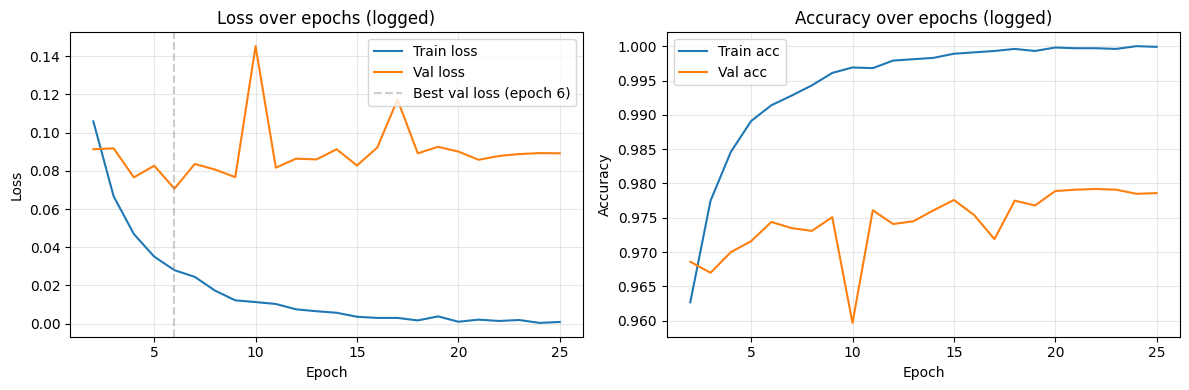

In [15]:
import matplotlib.pyplot as plt

# Manual history from provided log (epochs 2–25)
epochs_logged = list(range(2, 26))
train_losses_log = [
    0.1059, 0.0667, 0.0469, 0.0351, 0.0280, 0.0245, 0.0173, 0.0122, 0.0113,
    0.0103, 0.0075, 0.0065, 0.0057, 0.0036, 0.0030, 0.0030, 0.0017, 0.0038,
    0.0010, 0.0021, 0.0014, 0.0019, 0.0004, 0.0009
]
val_losses_log = [
    0.0913, 0.0918, 0.0766, 0.0827, 0.0707, 0.0836, 0.0807, 0.0767, 0.1453,
    0.0817, 0.0864, 0.0860, 0.0913, 0.0828, 0.0922, 0.1173, 0.0892, 0.0926,
    0.0901, 0.0858, 0.0878, 0.0888, 0.0893, 0.0892
]
train_accs_log = [
    0.9627, 0.9775, 0.9846, 0.9891, 0.9914, 0.9928, 0.9943, 0.9961, 0.9969,
    0.9968, 0.9979, 0.9981, 0.9983, 0.9989, 0.9991, 0.9993, 0.9996, 0.9993,
    0.9998, 0.9997, 0.9997, 0.9996, 1.0000, 0.9999
]
val_accs_log = [
    0.9686, 0.9670, 0.9700, 0.9716, 0.9744, 0.9735, 0.9731, 0.9751, 0.9597,
    0.9761, 0.9741, 0.9745, 0.9761, 0.9776, 0.9754, 0.9719, 0.9775, 0.9768,
    0.9789, 0.9791, 0.9792, 0.9791, 0.9785, 0.9786
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(epochs_logged, train_losses_log, label="Train loss")
axes[0].plot(epochs_logged, val_losses_log, label="Val loss")
axes[0].axvline(6, color='gray', linestyle='--', alpha=0.4, label="Best val loss (epoch 6)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss over epochs (logged)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_logged, train_accs_log, label="Train acc")
axes[1].plot(epochs_logged, val_accs_log, label="Val acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy over epochs (logged)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = criterion(
    torch.from_numpy(
        np.stack(
            [1 - np.array(all_probs), np.array(all_probs)],
            axis=1,
        )
    ),
    torch.from_numpy(np.array(all_labels, dtype=np.int64)),
).item()  

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print("\nTest results:")
print(f"  Loss:       {test_loss:.4f}")
print(f"  Accuracy:   {acc:.4f}")
print(f"  Precision:  {prec:.4f}")
print(f"  Recall:     {rec:.4f}")
print(f"  F1-score:   {f1:.4f}")
print(f"  ROC-AUC:    {auc:.4f}\n")

print("Confusion matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))



Test results:
  Loss:       0.3343
  Accuracy:   0.9786
  Precision:  0.9821
  Recall:     0.9750
  F1-score:   0.9785
  ROC-AUC:    0.9966

Confusion matrix:
[[3143   57]
 [  80 3120]]

Classification report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      3200
        Fake       0.98      0.97      0.98      3200

    accuracy                           0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400



In [ ]:
model.save_pretrained(OUTPUT_DIR)
print(f"\nModel saved to: {OUTPUT_DIR}")

import json
transform_config = {
    "resize": [224, 224],
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225]
}
with open(OUTPUT_DIR / "transform_config.json", "w") as f:
    json.dump(transform_config, f)
print("Transform config saved.")



Model saved to: E:\University\FS2025\Scientific Writing\Project\vit_deepfake_model
Transform config saved.
